In [3]:
import pandas as pd
from sklearn import datasets

# Load the Iris dataset
iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target  # Add the target labels

# Save to CSV
df.to_csv("iris_dataset.csv", index=False)
print("Iris dataset saved as 'iris_dataset.csv'")


Iris dataset saved as 'iris_dataset.csv'


In [4]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("iris_dataset.csv")

# Select two classes for binary classification (e.g., Setosa vs Versicolor)
df = df[df['target'] != 2]  # Remove class '2' (Virginica)
X = df.iloc[:, :-1].values  # Features
Y = df['target'].values  # Labels

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32).reshape(-1, 1)

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

# Define quantum device
n_qubits = 4  # One qubit per feature
dev = qml.device("default.qubit", wires=n_qubits)

# Define quantum circuit
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

# Define Quantum Neural Network
class QNN(nn.Module):
    def __init__(self):
        super(QNN, self).__init__()
        self.weights = nn.Parameter(torch.randn((3, n_qubits, 3)))  # Trainable parameters

    def forward(self, x):
        return quantum_circuit(x, self.weights)

# Initialize model
model = QNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss

# Ensure Y_train is float32 and matches X_train in size
Y_train = Y_train.float().reshape(-1)  # Use Y_train from train_test_split

# Training loop
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Compute outputs (ensure same batch size as Y_train)
    outputs = torch.sigmoid(torch.stack([model(x) for x in X_train])).float().reshape(-1)

    # Compute loss
    loss = loss_fn(outputs, Y_train)  # Both now have shape (80,)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# Evaluate on test data
with torch.no_grad():
    predictions = torch.sigmoid(torch.stack([model(x) for x in X_test]))
    predictions = (predictions.numpy() > 0.5).astype(int)
    accuracy = np.mean(predictions.flatten() == Y_test.numpy().flatten())

print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 0: Loss = 0.7013
Epoch 10: Loss = 0.5898
Epoch 20: Loss = 0.5051
Epoch 30: Loss = 0.4588
Epoch 40: Loss = 0.4290
Test Accuracy: 100.00%


In [5]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [6]:
# Load dataset
df = pd.read_csv("iris_dataset.csv")
print(df.head())

# Select two classes for binary classification (e.g., Setosa vs Versicolor)
df = df[df['target'] != 2]  # Remove class '2' (Virginica)
X = df.iloc[:, :-1].values  # Features
Y = df['target'].values  # Labels

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to tensors - explicitly specify dtype as float32
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32).reshape(-1, 1)

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


In [7]:
# Define quantum device with explicit dtype specification
n_qubits = 4  # Number of qubits
dev = qml.device("default.qubit", wires=n_qubits)

In [8]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(inputs, weights):
    # Encode data
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
    
    # Apply parameterized quantum layers
    for j in range(3):
        for i in range(n_qubits):
            qml.RX(weights[j, i, 0], wires=i)
            qml.RZ(weights[j, i, 1], wires=i)
            qml.CNOT(wires=[i, (i + 1) % n_qubits])
    
    # Return a single expectation value for binary classification
    return qml.expval(qml.PauliZ(0))

In [9]:
def visualize_circuit(sample_input=None, model=None):
    """
    Visualize the quantum circuit.
    
    Args:
        sample_input: A sample input tensor to use for visualization
        model: The QNN model with trained weights (if available)
    """
    if sample_input is None:
        # Create a dummy input if none provided
        sample_input = torch.tensor([0.1, 0.2, 0.3, 0.4], dtype=torch.float32)
    
    # Define a circuit for visualization purposes
    dev_vis = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev_vis)
    def vis_circuit(inputs, weights=None):
        # Encode data
        for i in range(n_qubits):
            qml.RY(inputs[i], wires=i)
        
        if weights is not None:
            # Apply parameterized quantum layers
            for j in range(3):
                for i in range(n_qubits):
                    qml.RX(weights[j, i, 0], wires=i)
                    qml.RZ(weights[j, i, 1], wires=i)
                    qml.CNOT(wires=[i, (i + 1) % n_qubits])
        else:
            # If no weights provided, use random values for visualization
            rand_weights = torch.randn(3, n_qubits, 2)
            for j in range(3):
                for i in range(n_qubits):
                    qml.RX(rand_weights[j, i, 0], wires=i)
                    qml.RZ(rand_weights[j, i, 1], wires=i)
                    qml.CNOT(wires=[i, (i + 1) % n_qubits])
        
        # Return something just to make the circuit execute
        return qml.expval(qml.PauliZ(0))
    
    # Get weights from model if provided
    weights_to_use = None
    if model is not None:
        weights_to_use = model.weights.detach()
    
    # Text representation of the circuit
    circuit_diagram = qml.draw(vis_circuit)(sample_input, weights_to_use)
    print("Quantum Circuit Diagram (Text):")
    print(circuit_diagram)
    
    # Visual representation using matplotlib
    fig, ax = plt.subplots(figsize=(12, 8))
    try:
        # Use qml.draw_mpl which returns a matplotlib figure
        circuit_fig = qml.draw_mpl(vis_circuit)(sample_input, weights_to_use)
        plt.close(fig)  # Close the empty figure we created
        plt.figure(circuit_fig.number)  # Focus on the circuit figure
        plt.tight_layout()
        plt.show()
        return circuit_diagram, circuit_fig
    except Exception as e:
        return circuit_diagram

In [10]:
class QNN(nn.Module):
    def __init__(self):
        super(QNN, self).__init__()
        # Explicitly set dtype to float32
        self.weights = nn.Parameter(torch.randn(3, n_qubits, 2, dtype=torch.float32))
        self.post_processing = nn.Linear(1, 1, dtype=torch.float32)  # Ensure float32

    def forward(self, x):
        # Ensure input is float32
        x = x.to(torch.float32)
        # Get quantum output and explicitly convert to float32
        q_output = quantum_circuit(x, self.weights)
        # Ensure the tensor is float32 before passing to Linear
        q_output_float = q_output.float()
        return self.post_processing(q_output_float.reshape(-1, 1))

Initial Circuit Visualization:
Quantum Circuit Diagram (Text):
0: ──RY(0.36)───RX(0.70)──RZ(-0.63)─╭●────────────────────────────────────────────────────────
1: ──RY(-0.63)──────────────────────╰X──RX(0.12)──RZ(0.07)─╭●─────────────────────────────────
2: ──RY(1.14)──────────────────────────────────────────────╰X──RX(0.15)──RZ(0.35)─╭●──────────
3: ──RY(0.91)─────────────────────────────────────────────────────────────────────╰X──RX(0.07)

────────────╭X──RX(1.23)──RZ(-0.59)─╭●────────────────────────────────────────────────────────
────────────│───────────────────────╰X──RX(0.01)──RZ(0.08)─╭●─────────────────────────────────
────────────│──────────────────────────────────────────────╰X──RX(0.05)──RZ(0.79)─╭●──────────
───RZ(1.76)─╰●────────────────────────────────────────────────────────────────────╰X──RX(1.37)

────────────╭X──RX(-2.18)──RZ(0.56)─╭●───────────────────────────────────────────────────────────
────────────│───────────────────────╰X──RX(-0.66)──RZ(0.27)─╭●───────────────

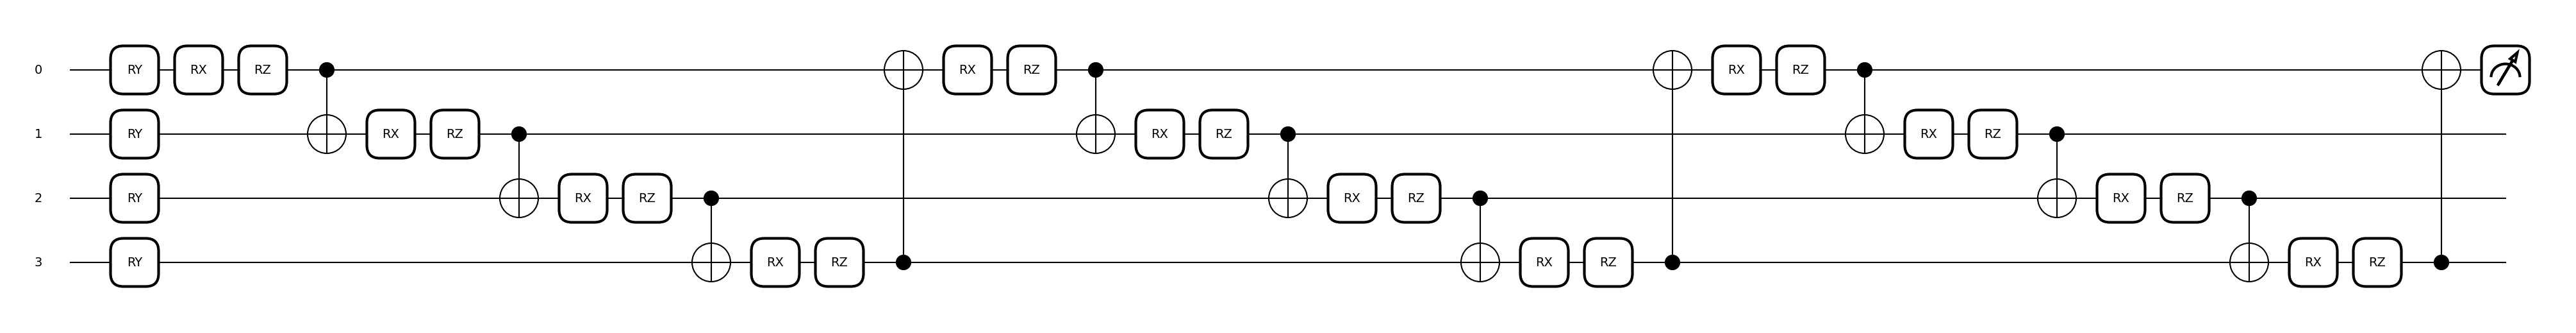

In [11]:
# Initialize model
model = QNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()  # Binary cross entropy with logits

# Visualize the initial circuit
print("Initial Circuit Visualization:")
initial_diagram = visualize_circuit(X_train[0], model)

In [12]:
# Training loop
epochs = 10
batch_size = 4

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    
    # Process in mini-batches
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_Y = Y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = torch.zeros(len(batch_X), 1, dtype=torch.float32)  # Explicitly float32
        
        # Process each example in the batch
        for j, x in enumerate(batch_X):
            # Ensure x is float32
            x = x.to(torch.float32)
            outputs[j] = model(x)
        
        # Compute loss
        loss = loss_fn(outputs, batch_Y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    if epoch % 2 == 0:
        print(f"Epoch {epoch}: Loss = {epoch_loss:.4f}")

Epoch 0: Loss = 12.9909
Epoch 2: Loss = 9.6085
Epoch 4: Loss = 6.6649
Epoch 6: Loss = 4.5606
Epoch 8: Loss = 3.0764


Test Accuracy: 100.00%

Trained Circuit Visualization:
Quantum Circuit Diagram (Text):
0: ──RY(0.83)───RX(0.89)──RZ(-0.21)─╭●────────────────────────────────────────────────────────
1: ──RY(-0.84)──────────────────────╰X──RX(0.79)──RZ(0.52)─╭●─────────────────────────────────
2: ──RY(1.55)──────────────────────────────────────────────╰X──RX(0.98)──RZ(1.42)─╭●──────────
3: ──RY(1.45)─────────────────────────────────────────────────────────────────────╰X──RX(0.10)

────────────╭X──RX(1.58)──RZ(-0.10)─╭●─────────────────────────────────────────────────────────
────────────│───────────────────────╰X──RX(-0.01)──RZ(0.23)─╭●─────────────────────────────────
────────────│───────────────────────────────────────────────╰X──RX(0.06)──RZ(0.79)─╭●──────────
───RZ(0.11)─╰●─────────────────────────────────────────────────────────────────────╰X──RX(1.87)

────────────╭X──RX(-2.18)──RZ(0.56)─╭●───────────────────────────────────────────────────────────
────────────│───────────────────────╰X──RX(-1.39)

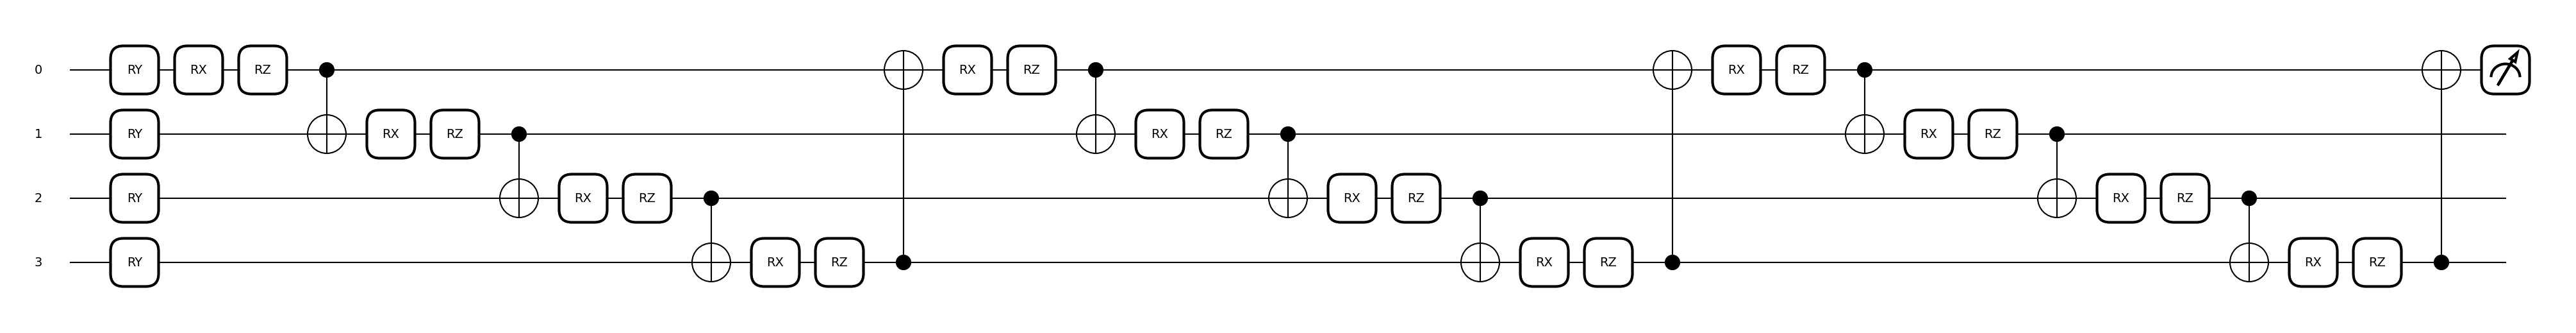

In [13]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    correct = 0
    total = len(X_test)
    for i, x in enumerate(X_test):
        # Ensure x is float32
        x = x.to(torch.float32)
        pred = torch.sigmoid(model(x))
        predicted_class = 1 if pred > 0.5 else 0
        if predicted_class == Y_test[i].item():
            correct += 1
    
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Visualize the trained circuit
print("\nTrained Circuit Visualization:")
trained_diagram = visualize_circuit(X_test[0], model)